In [3]:
import src.register_optimizer as regop
import src.QAOA_func as QAOAop
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import DigitalAnalogDevice

import src.register_optimizer as regop

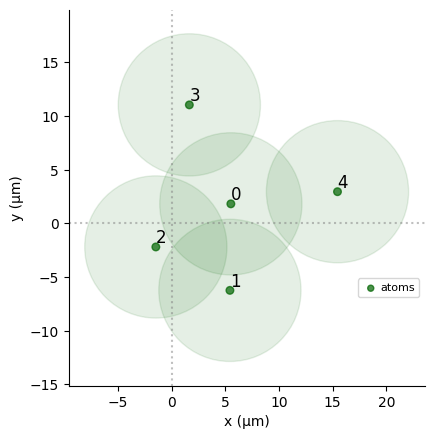

In [6]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

LAYERS=2

reg = regop.optimized_register(Q)
regop.draw_register(reg)


# np.random.seed(123)  # ensures reproducibility of the tutorial
# guess = {
#     "t": np.random.uniform(8, 10, LAYERS),
#     "s": np.random.uniform(1, 3, LAYERS),
# }

# example_dict = QAOAop.quantum_loop(np.r_[guess["t"], guess["s"]],LAYERS)

# QAOAop.plot_distribution(example_dict)


In [11]:
def quantum_loop_circuit(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

def function(param, *args):
    Q = args[0]
    C = quantum_loop_circuit(np.r_[guess["t"], guess["s"]],LAYERS,Q)
    cost = get_cost(C, Q)
    return cost

scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            function,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass


In [10]:
optimal_count_dict = QAOAop.quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)


ValueError: attempt to get argmin of an empty sequence

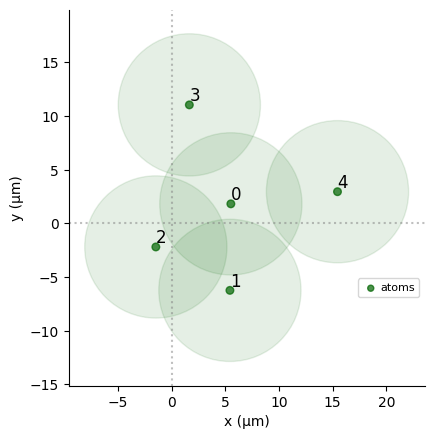

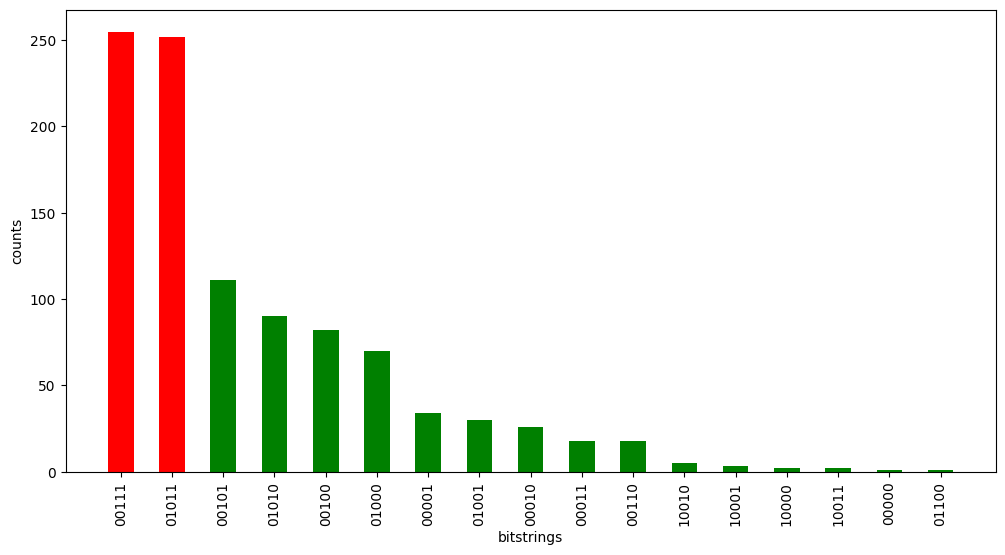

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import src.register_optimizer as regop
import src.QAOA_func as QAOA
import src.qubo as qb


def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = qb.get_cost(C, Q)
    return cost

def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)


shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    regop.evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

reg = regop.optimized_register(Q)
regop.draw_register(reg)

LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")


scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

optimal_count_dict = quantum_loop(params[np.argmin(scores)])

QAOA.plot_distribution(optimal_count_dict)